# Admissible Machine Learning - Python Version

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissible.html

## TODO

Debug Python version errors (works in R version) - due to installation?:
    
```
AttributeError: module 'h2o.explanation' has no attribute 'disparate_analysis'

AttributeError: type object 'ModelBase' has no attribute 'fairness_metrics'

AttributeError: type object 'ModelBase' has no attribute 'inspect_model_fairness'
```

We have developed new tools to aid in the design of *admissible learning algorithms* which are:

- **efficient** (enjoy good predictive accuracy)

- **fair** (minimize discrimination against minority groups)

- **interpretable** (provide mechanistic understanding)

to the best possible extent.

Admissible ML introduces two methodological tools:

- **Infogram** - an “information diagram”, is a new graphical feature-exploration method that facilitates the development of admissible machine learning methods

- **L-features** - mitigate unfairness, offer ways to systematically discover the hidden problematic proxy features from a dataset
    + L-features are inadmissible features

The Infogram and Admissible Machine Learning bring a new research direction to machine learning interpretability. You can find the theoretical foundations and several real-life examples of its utility in the Admissible ML paper:

https://arxiv.org/abs/2108.07380

Below we introduce the concepts at a high level and provide an example using the H2O Infogram implementation.

## Infogram

The infogram is a graphical information-theoretic interpretability tool which allows the user to quickly spot the core, decision-making variables that uniquely and safely drive the response in supervised classification problems. The infogram can significantly cut down the number of predictors needed to build a model by identifying only the most valuable, admissible features.

When protected variables such as race or gender are present in the data, the admissibility of a variable is determined by a safety and relevancy index which serves as a diagnostic tool for fairness. The safety of each feature can be quantified, and variables that are unsafe will be considered inadmissible. Models built using only admissible features will naturally be more interpretable given the reduced feature set. Admissible models are also less susceptible to overfitting and train faster, often while providing similar accuracy as models built using all available features.

### Core Infogram

The infogram is an information-theoretic graphical tool which allows the user to quickly spot the “core” decision-making variables that are driving the response. Identifying the Core Set is a much more difficult undertaking than merely selecting the most predictive features. One of the main advantages of this method is that it works even in the presence of correlated features. There are additional benefits as well: machine learning models based on “core” features show improved stability, especially when there exists considerable correlation among the features.

The Core Infogram plots all the variables as points on a two-dimensional grid of **total vs net information**. The x-axis is **total information**, a measure of how much the variable drives the response (the more predictive, the higher the total information). The y-axis is **net information**, a measure of how unique the variable is. The top right quadrant of the infogram plot is the **admissible section**; the variables located in this quadrant are the **admissible features**. In the Core Infogram, the admissible features are the strongest, unique drivers of the response.

### Fair Infogram: A Diagnostic Tool for Fairness

To improve fairness, you must remove any variables that are of a protected class. It is bad practice, yet common, that modelers remove the protected variables alone. With potentially correlated features (e.g. zip code, income, etc.) still present in the training data, unfair models can be trained, unbeknownst to the data scientist. This is called “fairness through unawareness.” The proxy attributes (e.g. zip code, income, etc.) share some degree of correlation (information-sharing) with race, gender, or age, so they must be systematically identified and also removed from the set of training features.

In the Fair Infogram, a non-protected predictor variable will be deemed “inadmissible” if it is found to possess little or no informational value beyond its use as a dummy for protected attributes when checked. The Fair Infogram plots all the features as points on a two-dimensional grid of **relevance vs safety**. The x-axis is the **relevance index**, a measure of how much the variable drives the response (the more predictive, the higher the relevance). The y-axis is the **safety index**, a measure of how much extra information the variable has that is not acquired through the protected variables. The **admissible features** are the strongest, safest drivers of the response.

The goal of this tool is to assist the identification of admissible features which have little or no information-overlap with protected attributes yet are reasonably predictive for the response.

## Infogram Interface

The interface is designed to be simple and aligned with the standard modeling interface in H2O. If you provide a list of protected features with `protected_columns`, it will produce a Fair Infogram instead of a Core Infogram. The infogram object is a data object which also contains the plot, and the plot can be displayed by calling `plot()` on the infogram object.

```
# Generate and plot the infogram
ig = H2OInfogram()
ig.train(x=x, y=y, training_frame=train)
ig.plot()
```

### Parameters

The infogram function follows the standard modeling interface in H2O, where the user specifies the following data variables: 

- `x`

- `y`

- `training_frame`

- `validation_frame`

In addition to the standard set of arguments, the infogram features several new arguments, which are all optional:

- **`algorithm`:** Machine learning algorithm used to build the infogram:
    + `"AUTO"` (GBM) - This is the default
    + `"deeplearning"` (Deep Learning with default parameters)
    + `"drf"` (Random Forest with default parameters)
    + `"gbm"` (GBM with default parameters)
    + `"glm"` (GLM with default parameters)
    + `"xgboost"` (if available, XGBoost with default parameters)

- **`algorithm_params`:** With `algorithm`, you can also specify a list of customized parameters for that algorithm
    + For example if we use a GBM, we can specify `list(max_depth = 10)` in R and `{'max_depth': 10}` in Python

- **`protected_columns`:** Columns that contain features that are sensitive and need to be protected (legally, or otherwise), if applicable
    + These features (e.g. race, gender, etc.) should not drive the prediction of the response

- **`net_information_threshold`:** A number between 0 and 1 representing a threshold for net information, defaulting to 0.1
    + For a specific feature, if the net information is higher than this threshold, and the corresponding total information is also higher than the `total_information_threshold`, that feature will be considered admissible
    + The net information is the y-axis of the Core Infogram

- **`total_information_threshold`:** A number between 0 and 1 representing a threshold for total information, defaulting to 0.1
    + For a specific feature, if the total information is higher than this threshold, and the corresponding net information is also higher than the threshold `net_information_threshold`, that feature will be considered admissible
    + The total information is the x-axis of the Core Infogram

- **`safety_index_threshold`:** A number between 0 and 1 representing a threshold for the safety index, defaulting to 0.1
    + This is only used when `protected_columns` is set by the user
    + For a specific feature, if the safety index value is higher than this threshold, and the corresponding relevance index is also higher than the `relevance_index_threshold`, that feature will be considered admissible
    + The safety index is the y-axis of the Fair Infogram

- **`relevance_index_threshold`:** A number between 0 and 1 representing a threshold for the relevance index, defaulting to 0.1
    + This is only used when `protected_columns` is set by the user
    + For a specific feature, if the relevance index value is higher than this threshold, and the corresponding safety index is also higher than the `safety_index_threshold`, that feature will be considered admissible
    + The relevance index is the x-axis of the Fair Infogram

- **`data_fraction`:** The fraction of the training frame to use to build the infogram model
    + Defaults to 1.0, and any value between 0 and 1.0 is acceptable

- **`top_n_features`:** An integer specifying the number of columns to evaluate in the infogram
    + The columns are ranked by variable importance, and the top N are evaluated
    + Defaults to 50

## Infogram Output

### Infogram Plot

The infogram function produces a visual guide to admissibility of the features. The visualization engine used in the R interface is the ggplot2 package and in Python, we use matplotlib. 

https://ggplot2.tidyverse.org/

https://matplotlib.org/

Here’s an example of the Core Infogram for the Iris dataset.

H2O Core Infogram

- **L-Features:** The highlighted L-shaped area contains features that are either irrelevant or redundant (or both), categorized as follows:
    + top left: Contains highly unique information, but only a small amount of relevance
    + origin: Contains low amount of unique information and low relevance
    + bottom right: Contains low amount of unique information, but high relevance

- **Admissible Features:** The features that are not in the L-Features set are the admissible features; in each quadrant have different attributes and value to the model:
    + top right: Contains highly unique and relevant information
    + top left: Contains highly unique, but minimally relevant information
    + bottom right: Contains low amount of unique information, but high relevance

### Infogram Data

The infogram function produces an object of type `H2OInfogram`, which contains several data elements and the plot object. The most important objects are the following:

- **`admissible_features`:** A list of the admissible feature column names

- **`admissible_score`:** A data frame storing various admissibility scores for each feature
    + The rows of the admissible score frame are the features which were evaluated (this will max out at 50 rows/features if `top_n_features` is left at the default)
    + Core and Fair Infograms have different interpretations of conditional mutual information (CMI), so the CMI and relevance columns use different names between the two infogram types
    + The frame is sorted by the admissible index column, with the most admissible features at the top of the table, for easy access
    
The columns in the admissible score frame are:

- **`admissible`:** Binary indicator of admissibility (1 = admissible, 0 = inadmissible)

- **`admissible_index`:** The normalized distance between the origin and the (x, y) feature location on the infogram plot
    + The rows of the data frame are sorted by this column

- **`total_information_index / relevance_index`:** A normalized measure of the relevance of the feature to the response variable
    + Higher is more relevant, more predictive, of the response
    + For Core infograms, this is Total Information Index and for Fair Infograms, it’s referred to as the Relevance Index

- **`net_information_index` / `safety_index`:** This column contains the normalized conditional mutual information (CMI)
    + In the case of a Core Infogram, CMI represents how unique the information in the feature is among all the predictors
    + For Fair Infograms, the safety index represents how safe a feature is to use, with respect to the specified protected columns

- **`cmi_raw`:** Raw conditional mutual information (CMI) value

If the user provided a `validation_frame` or turned on cross-validation (`nfolds`) through the optional `algorithm_params` argument, then additional admissible score frames (valid and/or CV) will be generated and stored in the output in addition to the default admissible score frame, which is generated using the `training_frame`. Comparing the training and validation infograms could help discern whether there’s overfitting.

## Code Examples

The R and Python code below is the quickest way to get started.

Here’s an example showing basic usage of the `h2o.infogram()` function in R and the `H2OInfogram()` method in Python. Keep in mind that this code should be run in an environment that can support plots.

### Infogram Example: UCI Credit

This example below uses a UCI Credit dataset from the UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

It has 30k rows, representing customers, and 24 predictor variables, including several common protected attributes such as sex, age, and marital status:

https://www.consumerfinance.gov/fair-lending/

This is a binary classification problem, aimed to estimate the probability of default in order to identify “credible or not credible” customers.

Along with the demographic variables that are included in this dataset, there’s a number of payment history variables, including previous bill and payment amounts. On the surface, you may assume that payment history is not correlated with protected variables, but as we will see in the example below, most of the payment history variables provide a hidden pathway through the protected variables to the response. Therefore, even if you remove the protected variables during training, the resulting model can still be discriminatory if any non-admissible bill/payment variables are included. This is Example 9 from the Admissible ML paper:

https://arxiv.org/abs/2108.07380

The code below generates an infogram, and we plot the infogram and view the data in the admissible score frame.

In [1]:
import h2o
from h2o.estimators.infogram import H2OInfogram

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_362"; OpenJDK Runtime Environment (build 1.8.0_362-b08); OpenJDK 64-Bit Server VM (build 25.362-b08, mixed mode)
  Starting server from /home/stever7/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp58ib15gv
  JVM stdout: /tmp/tmp58ib15gv/h2o_stever7_started_from_python.out
  JVM stderr: /tmp/tmp58ib15gv/h2o_stever7_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"1 year, 3 months and 19 days !!!"
H2O_cluster_name:,H2O_from_python_stever7_gdikyn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.63 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"locked, healthy"


In [3]:
# Import credit dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/taiwan_credit_card_uci.csv"

col_types = {'SEX': "enum", 'MARRIAGE': "enum", 'default_payment_next_month': "enum"}

df = h2o.import_file(path=f, col_types=col_types)

# We will split the data so that we can test/compare performance
# of admissible vs non-admissible models later
train, test = df.split_frame(seed=1)

# Response column and predictor columns
y = "default_payment_next_month"
x = train.columns
x.remove(y)

# Protected columns
pcols = ["SEX", "MARRIAGE", "AGE"]

# Infogram
ig = H2OInfogram(protected_columns=pcols)
ig.train(y=y, x=x, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Model Details
H2OInfogram :  Information Diagram
Model Key:  Infogram_model_python_1685906642519_1

No model summary for this model


Here’s the infogram which shows that `PAY_0` and `PAY_2` are the only admissible attributes, given the default thresholds. Most of the bill or payment features either have low predictive value, or low predicted value and are unsafe.

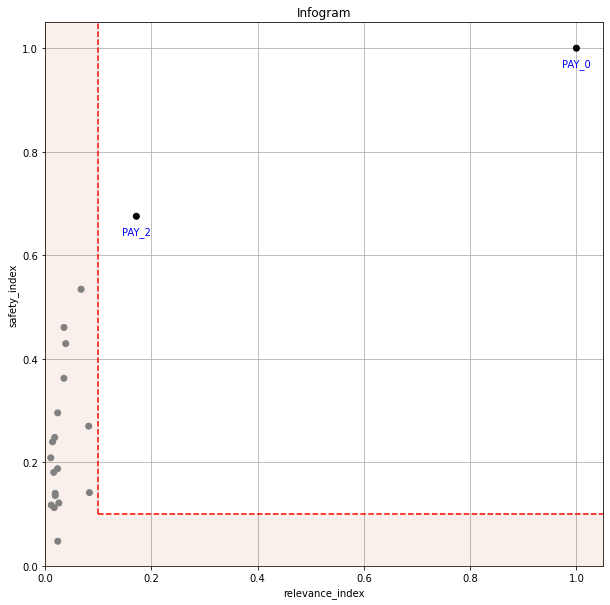

In [4]:
ig.plot()

Notice the position of `PAY_0` in the plot. This indicates that this is a highly relevant and safe variable to use in the model. The `PAY_2` variable is also reasonably safe to use, but it’s not as predictive of the response. The remaining variables are neither highly predictive of the response nor very safe to use in the model. So, you may consider building a model using just the two admissible variables. To increase accuracy, you could add in some non-admissible, relevant variables; however, since this will be at a cost to safety, this is an important consideration. In many cases, the potential for increased accuracy might be minimal and not worthy of pursuing, or in the case where the safety is a strict requirement, the pursuit is simply not admissible.

In [5]:
# Admissible score frame
asf = ig.get_admissible_score_frame()
asf

column,admissible,admissible_index,relevance_index,safety_index,cmi_raw
PAY_0,1,1,1,1,0.112279
PAY_2,1,0.492743,0.171901,0.675308,0.0758232
PAY_3,0,0.380858,0.0679482,0.534311,0.0599921
PAY_4,0,0.326652,0.0357614,0.460569,0.0517124
PAY_5,0,0.304824,0.038993,0.429319,0.0482037
PAY_6,0,0.257505,0.0356299,0.36242,0.0406923
PAY_AMT1,0,0.209696,0.0239471,0.295587,0.0331883
LIMIT_BAL,0,0.199571,0.0823281,0.269961,0.0303111
PAY_AMT2,0,0.175918,0.0183668,0.248107,0.0278573
PAY_AMT3,0,0.169678,0.0142864,0.239536,0.0268949


### Infogram Example: HMDA

The Home Mortgage Disclosure Act (HMDA) is a United States federal law that requires certain financial institutions to maintain, report, and publicly disclose loan-level information about mortgages:

https://en.wikipedia.org/wiki/Home_Mortgage_Disclosure_Act

These data help show whether lenders are serving the housing needs of their communities; they give public officials information that helps them make decisions and policies; and they shed light on lending patterns that could be discriminatory. The public data are modified to protect applicant and borrower privacy.

The mortgage dataset analyzed here is a random sample of consumer-anonymized loans from the HMDA database:

https://www.consumerfinance.gov/data-research/hmda/

These loans are a subset of all originated mortgage loans in the 2018 HMDA data that were chosen to represent a relatively comparable group of consumer mortgages.

The dataset has 93k rows, representing people who applied for mortgages, and a variety of predictor variables, including several common protected attributes such as (derived) sex, ethnicity, race, as well as two columns (encodings) of age:

https://www.consumerfinance.gov/fair-lending/

This is a binary classification problem, aimed at trying to predict whether an applicant will get a “high-priced” loan. High-priced is defined as: the annual percentage rate (APR) that was charged was 150 basis points (1.5%) or more above a survey-based estimate of other similar loans offered around the time of the given loan.

The code below generates an infogram, and we plot the infogram and view the data in the admissible score frame.

In [6]:
import h2o
from h2o.estimators.infogram import H2OInfogram

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_362"; OpenJDK Runtime Environment (build 1.8.0_362-b08); OpenJDK 64-Bit Server VM (build 25.362-b08, mixed mode)
  Starting server from /home/stever7/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqybwbsnr
  JVM stdout: /tmp/tmpqybwbsnr/h2o_stever7_started_from_python.out
  JVM stderr: /tmp/tmpqybwbsnr/h2o_stever7_started_from_python.err
  Server is running at http://127.0.0.1:54329
Connecting to H2O server at http://127.0.0.1:54329 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"1 year, 3 months and 19 days !!!"
H2O_cluster_name:,H2O_from_python_stever7_i2tye2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.63 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"locked, healthy"


In [8]:
# Import HDMA dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/hmda_lar_2018_sample.csv"

col_types = {'high_priced': "enum"}

df = h2o.import_file(path=f, col_types=col_types)

# We will split the data so that we can test/compare performance
# of admissible vs non-admissible models later
train, test = df.split_frame(ratios=[0.8], seed=1)

# Response column and predictor columns
y = "high_priced"

x =  ["loan_amount",
      "loan_to_value_ratio",
      "loan_term",
      "intro_rate_period",
      "property_value",
      "income",
      "debt_to_income_ratio"]

# Protected columns
pcols = ["derived_ethnicity",
         "derived_race",
         "derived_sex",
         "applicant_age",
         "applicant_age_above_62"]

# Infogram
ig = H2OInfogram(protected_columns=pcols)
ig.train(y=y, x=x, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Model Details
H2OInfogram :  Information Diagram
Model Key:  Infogram_model_python_1685906661214_1

No model summary for this model


Here’s the infogram which shows that `loan_to_value_ratio`, `property_value` and `loan_amount` are the only admissible attributes, given the default thresholds. The three features, `loan_term`, `intro_rate_perio`, `income` and `debt_to_income_ratio` either have low predictive value, or low predicted value and are unsafe.

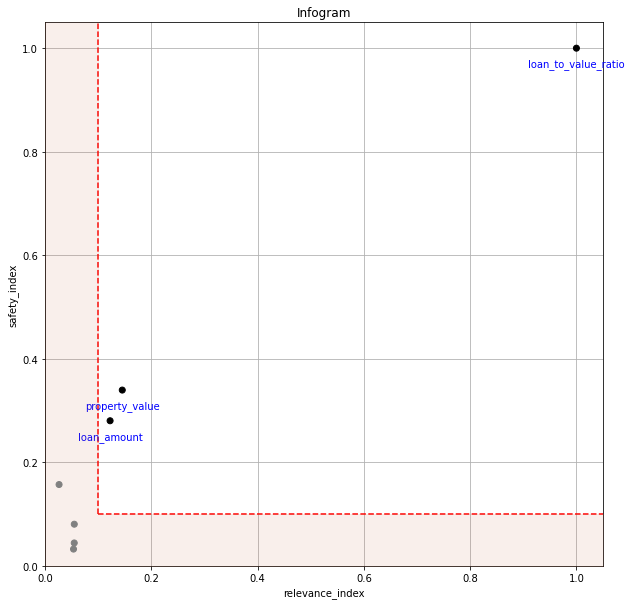

In [9]:
ig.plot()

In [10]:
# Admissible score frame
asf = ig.get_admissible_score_frame()
asf

column,admissible,admissible_index,relevance_index,safety_index,cmi_raw
loan_to_value_ratio,1,1,1,1,0.0858826
property_value,1,0.261233,0.145431,0.33961,0.0291666
loan_amount,1,0.21634,0.122526,0.280346,0.0240768
income,0,0.112692,0.0265004,0.157151,0.0134966
intro_rate_period,0,0.0690115,0.0551325,0.0805331,0.00691639
loan_term,0,0.0499792,0.0550699,0.0443075,0.00380524
debt_to_income_ratio,0,0.0443668,0.0537012,0.0324501,0.0027869


Notice the position of `loan_to_value_ratio` in the plot. This indicates that this is a highly relevant and safe variable to use in the model. The `property_value` and `loan_amount` variables are less safe to use and are somewhat predictive of the response and are also admissible under these settings. The remaining variables are neither highly predictive of the response nor very safe to use in the model. In the next two sections below, we will build models comparing admissible machine learning with models trained using inadmissible, un-safe features.

### Admissible ML

We can use the admissible features to train a model. When interpretability is the goal, you can train an interpretable model such as a decision tree, GLM, or GAM using the admissible features. However, you can also train a more complex machine learning model such as a Gradient Boosting Machine (GBM) using only the admissible features.

Using the HMDA infogram example above, we can extend the infogram analysis to evaluate the accuracy between admissible and inadmissible models.

In [11]:
# Building on the HMDA code as above, we train and evaluate an Admissible GBM and
# compare that with a GBM trained on all unprotected features:

# Admissible columns
acols = ig.get_admissible_features()

# Unprotected columns
ucols = list(set(x).difference(pcols))

# Train an Admissible GBM
from h2o.estimators.gbm import H2OGradientBoostingEstimator
agbm = H2OGradientBoostingEstimator(seed=1)
agbm.train(x=acols, y=y, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_86


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21282.0,5.0,5.0,5.0,16.0,32.0,29.3




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0864405744473262
RMSE: 0.2940077795693954
LogLoss: 0.28896114953808366
Mean Per-Class Error: 0.26179176536259197
AUC: 0.8272695325655177
AUCPR: 0.4120957949059812
Gini: 0.6545390651310354

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2484446014643407: 


,,0,1,Error,Rate
0,0,56084.0,9130.0,0.14,(9130.0/65214.0)
1,1,3458.0,5557.0,0.3836,(3458.0/9015.0)
2,Total,59542.0,14687.0,0.1696,(12588.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.248445,0.468906,166.0
1,max f2,0.111368,0.587733,262.0
2,max f0point5,0.317881,0.444001,117.0
3,max accuracy,0.451260,0.882472,51.0
4,max precision,0.655857,0.952381,5.0
5,max recall,0.015822,1.000000,397.0
6,max specificity,0.707870,0.999985,0.0
7,max absolute_mcc,0.242729,0.390773,171.0
8,max min_per_class_accuracy,0.113205,0.761398,260.0
9,max mean_per_class_accuracy,0.111368,0.762040,262.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011545,0.511615,5.207465,5.207465,0.632439,0.570880,0.632439,0.570880,0.060122,0.060122,420.746480,420.746480,0.055292
1,2,0.020181,0.459013,4.341767,4.837030,0.527301,0.475060,0.587450,0.529878,0.037493,0.097615,334.176736,383.702952,0.088139
2,3,0.030770,0.429825,4.190302,4.614469,0.508906,0.443482,0.560420,0.500146,0.044370,0.141986,319.030200,361.446917,0.126590
3,4,0.040079,0.409198,3.836946,4.433875,0.465991,0.418935,0.538487,0.481283,0.035718,0.177704,283.694614,343.387475,0.156650
4,5,0.050439,0.396117,3.736861,4.290711,0.453836,0.401172,0.521100,0.464829,0.038713,0.216417,273.686119,329.071144,0.188923
5,6,0.101955,0.344124,3.305205,3.792749,0.401412,0.375264,0.460624,0.419573,0.170272,0.386689,230.520480,279.274931,0.324095
6,7,0.150022,0.283897,2.550030,3.394579,0.309697,0.308312,0.412267,0.383925,0.122573,0.509262,155.003013,239.457923,0.408900
7,8,0.201390,0.247813,2.198310,3.089450,0.266981,0.263220,0.375209,0.353137,0.112923,0.622185,119.830957,208.945004,0.478964
8,9,0.300004,0.115195,1.398196,2.533521,0.169809,0.173707,0.307692,0.294157,0.137881,0.760067,39.819558,153.352105,0.523660
9,10,0.403333,0.081433,0.738586,2.073681,0.089700,0.096866,0.251845,0.243614,0.076317,0.836384,-26.141420,107.368093,0.492915




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:24:43,0.003 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:24:44,0.030 sec,1.0,0.324753,0.364106,0.706640,0.230863,3.002855,0.292204
2,,2023-06-04 19:24:44,0.052 sec,2.0,0.323239,0.359643,0.708849,0.231911,2.964897,0.295841
3,,2023-06-04 19:24:44,0.077 sec,3.0,0.321962,0.355942,0.716584,0.236737,2.985115,0.351035
4,,2023-06-04 19:24:44,0.102 sec,4.0,0.317500,0.344032,0.789484,0.332495,4.654754,0.216236
5,,2023-06-04 19:24:44,0.128 sec,5.0,0.313911,0.335117,0.801430,0.356533,4.718868,0.197968
6,,2023-06-04 19:24:44,0.156 sec,6.0,0.310979,0.328109,0.806452,0.364572,4.744127,0.192822
7,,2023-06-04 19:24:44,0.199 sec,7.0,0.309985,0.325569,0.805629,0.364896,4.792135,0.199679
8,,2023-06-04 19:24:44,0.230 sec,8.0,0.307770,0.320478,0.808204,0.369398,4.815674,0.189845
9,,2023-06-04 19:24:44,0.252 sec,9.0,0.305977,0.316346,0.809631,0.370906,4.825675,0.190801



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,5624.819336,1.000000,0.739245
1,property_value,1102.354004,0.195980,0.144878
2,loan_amount,881.693420,0.156751,0.115877


In [12]:
# Train a GBM on all unprotected features
gbm = H2OGradientBoostingEstimator(seed=1)
gbm.train(x=ucols, y=y, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_138


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20851.0,5.0,5.0,5.0,20.0,32.0,28.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08407600858208494
RMSE: 0.2899586325358929
LogLoss: 0.279115390135508
Mean Per-Class Error: 0.24281937103325046
AUC: 0.8456938605695645
AUCPR: 0.4454590853830072
Gini: 0.691387721139129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2241867637643092: 


,,0,1,Error,Rate
0,0,55419.0,9795.0,0.1502,(9795.0/65214.0)
1,1,3024.0,5991.0,0.3354,(3024.0/9015.0)
2,Total,58443.0,15786.0,0.1727,(12819.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224187,0.483126,203.0
1,max f2,0.129911,0.604494,259.0
2,max f0point5,0.344342,0.461499,132.0
3,max accuracy,0.475461,0.885058,67.0
4,max precision,0.970617,1.000000,0.0
5,max recall,0.009099,1.000000,399.0
6,max specificity,0.970617,1.000000,0.0
7,max absolute_mcc,0.224187,0.410600,203.0
8,max min_per_class_accuracy,0.132315,0.773932,257.0
9,max mean_per_class_accuracy,0.129911,0.774461,259.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010063,0.542062,5.775885,5.775885,0.701473,0.596387,0.701473,0.596387,0.058125,0.058125,477.588535,477.588535,0.054706
1,2,0.020019,0.487134,5.013903,5.396945,0.608931,0.506986,0.655451,0.551927,0.049917,0.108042,401.390331,439.694542,0.100191
2,3,0.030837,0.456156,4.214384,4.982093,0.511831,0.467162,0.605068,0.522191,0.045591,0.153633,321.438449,398.209334,0.139771
3,4,0.040011,0.437124,4.086744,4.776796,0.496329,0.446228,0.580135,0.504773,0.037493,0.191126,308.674432,377.679614,0.172004
4,5,0.050034,0.413970,3.563615,4.533768,0.432796,0.426970,0.550619,0.489187,0.035718,0.226844,256.361530,353.376799,0.201251
5,6,0.100203,0.344403,3.391748,3.961990,0.411923,0.376598,0.481178,0.432817,0.170161,0.397005,239.174791,296.199026,0.337831
6,7,0.150372,0.269903,2.670946,3.531257,0.324382,0.307066,0.428866,0.390862,0.133999,0.531004,167.094620,253.125669,0.433249
7,8,0.200057,0.233923,2.174583,3.194326,0.264100,0.249671,0.387946,0.355798,0.108042,0.639046,117.458267,219.432647,0.499674
8,9,0.300004,0.126298,1.426151,2.605252,0.173204,0.178132,0.316404,0.296607,0.142540,0.781586,42.615141,160.525239,0.548155
9,10,0.400181,0.082983,0.771794,2.146286,0.093733,0.102233,0.260663,0.247950,0.077316,0.858902,-22.820622,114.628594,0.522134




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:24:45,0.009 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:24:45,0.044 sec,1.0,0.324671,0.363990,0.696397,0.241456,3.359279,0.297620
2,,2023-06-04 19:24:46,0.064 sec,2.0,0.323067,0.359513,0.702138,0.247839,3.435283,0.298940
3,,2023-06-04 19:24:46,0.082 sec,3.0,0.321542,0.355243,0.717035,0.256904,3.495057,0.225303
4,,2023-06-04 19:24:46,0.101 sec,4.0,0.316669,0.342289,0.800183,0.350938,4.681041,0.222784
5,,2023-06-04 19:24:46,0.126 sec,5.0,0.312752,0.332570,0.814826,0.375970,4.801201,0.193172
6,,2023-06-04 19:24:46,0.157 sec,6.0,0.309586,0.325067,0.821288,0.385777,4.785410,0.199855
7,,2023-06-04 19:24:46,0.182 sec,7.0,0.308817,0.323102,0.820899,0.384550,4.805743,0.184227
8,,2023-06-04 19:24:46,0.216 sec,8.0,0.306302,0.317315,0.824265,0.389959,4.822270,0.198359
9,,2023-06-04 19:24:46,0.247 sec,9.0,0.304260,0.312648,0.826306,0.392807,4.869814,0.190882



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,5766.845215,1.000000,0.685701
1,property_value,838.677185,0.145431,0.099722
2,loan_amount,706.587219,0.122526,0.084016
3,intro_rate_period,317.940521,0.055132,0.037804
4,loan_term,317.579681,0.055070,0.037762
5,debt_to_income_ratio,309.686707,0.053701,0.036823
6,income,152.823502,0.026500,0.018171


In [13]:
# Admissible GBM test AUC
agbm.model_performance(test).auc()  # 0.8141841

0.8141841492109441

In [14]:
# Inadmissible GBM test AUC
gbm.model_performance(test).auc()  # 0.8347159

0.8347159369140623

### Admissible AutoML

We can execute two AutoML runs to compare the accuracy of the models built on only admissible features, versus all the non-protected, unsafe features in the training set. We give each run the same amount of time to execute. There will be more models generated in the Admissible AutoML context, since the individual models train faster due to there being fewer features in the training set. Note that since the speed of model training depends on your hardware, the results below will not be reproducible (below are the results for a 40-core machine). Below we continue the HMDA example.

In [15]:
# Building on the HMDA infogram code, we execute AutoML with all unprotected features,
# and then we run AutoML with only the admissible features:

from h2o.automl import H2OAutoML

# Admissible AutoML
aaml = H2OAutoML(max_runtime_secs=60*10, seed=1)
aaml.train(x=acols, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20230604_192448

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07959108312111793
RMSE: 0.28211891663112193
LogLoss: 0.2637961044896141
Null degrees of freedom: 9920
Residual degrees of freedom: 9911
Null deviance: 7433.008676625575
Residual deviance: 5234.242305282924
AIC: 5254.242305282924
AUC: 0.871371390955723
AUCPR: 0.5244900442686052
Gini: 0.742742781911446

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2555212884077921: 


,,0,1,Error,Rate
0,0,7712.0,980.0,0.1127,(980.0/8692.0)
1,1,434.0,795.0,0.3531,(434.0/1229.0)
2,Total,8146.0,1775.0,0.1425,(1414.0/9921.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.255521,0.529294,186.0
1,max f2,0.115615,0.634488,264.0
2,max f0point5,0.428563,0.508449,110.0
3,max accuracy,0.428563,0.891241,110.0
4,max precision,0.909039,1.000000,0.0
5,max recall,0.009773,1.000000,393.0
6,max specificity,0.909039,1.000000,0.0
7,max absolute_mcc,0.255521,0.459096,186.0
8,max min_per_class_accuracy,0.116750,0.791701,263.0
9,max mean_per_class_accuracy,0.115615,0.793593,264.0



Gains/Lift Table: Avg response rate: 12.39 %, avg score: 12.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010281,0.639145,7.043579,7.043579,0.872549,0.752817,0.872549,0.752817,0.072417,0.072417,604.357919,604.357919,0.070921
1,2,0.020159,0.557057,5.848383,6.457933,0.724490,0.592729,0.800000,0.674374,0.057771,0.130187,484.838345,545.793328,0.125585
2,3,0.030037,0.503406,4.859924,5.932414,0.602041,0.530901,0.734899,0.627192,0.048007,0.178194,385.992428,493.241354,0.169105
3,4,0.040218,0.466528,3.916321,5.422074,0.485149,0.483272,0.671679,0.590761,0.039870,0.218063,291.632092,442.207431,0.202992
4,5,0.050197,0.441799,4.240057,5.187095,0.525253,0.453264,0.642570,0.563427,0.042311,0.260374,324.005720,418.709500,0.239896
5,6,0.100192,0.378165,3.189907,4.190510,0.395161,0.407109,0.519115,0.485426,0.159479,0.419854,218.990656,319.051003,0.364860
6,7,0.150086,0.289250,3.147427,3.843750,0.389899,0.335497,0.476158,0.435584,0.157038,0.576892,214.742708,284.374974,0.487154
7,8,0.200081,0.210544,2.099479,3.407902,0.260081,0.253751,0.422166,0.390149,0.104963,0.681855,109.947932,240.790182,0.549895
8,9,0.300071,0.103666,1.261315,2.692613,0.156250,0.143095,0.333557,0.307825,0.126119,0.807974,26.131509,169.261326,0.579718
9,10,0.400060,0.075172,0.781202,2.214881,0.096774,0.087401,0.274376,0.252733,0.078112,0.886086,-21.879839,121.488074,0.554747




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08388957288145069
RMSE: 0.28963696739444483
LogLoss: 0.2829907537449331
Null degrees of freedom: 74228
Residual degrees of freedom: 74216
Null deviance: 54901.25173894515
Residual deviance: 42012.241319465276
AIC: 42038.241319465276
AUC: 0.8311949509597831
AUCPR: 0.4523135163171292
Gini: 0.6623899019195663

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24557325034893707: 


,,0,1,Error,Rate
0,0,57071.0,8143.0,0.1249,(8143.0/65214.0)
1,1,3533.0,5482.0,0.3919,(3533.0/9015.0)
2,Total,60604.0,13625.0,0.1573,(11676.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.245573,0.484276,207.0
1,max f2,0.103302,0.588355,284.0
2,max f0point5,0.357781,0.466595,153.0
3,max accuracy,0.525343,0.886971,78.0
4,max precision,0.917331,1.000000,0.0
5,max recall,0.004544,1.000000,399.0
6,max specificity,0.917331,1.000000,0.0
7,max absolute_mcc,0.233156,0.407808,213.0
8,max min_per_class_accuracy,0.105942,0.761355,282.0
9,max mean_per_class_accuracy,0.107381,0.762439,281.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.636814,6.405410,6.405410,0.777927,0.743848,0.777927,0.743848,0.064115,0.064115,540.540956,540.540956,0.061585
1,2,0.020033,0.553915,5.013409,5.708941,0.608871,0.590548,0.693342,0.667146,0.050250,0.114365,401.340910,470.894127,0.107373
2,3,0.030110,0.500592,4.260075,5.224041,0.517380,0.524478,0.634452,0.619399,0.042928,0.157293,326.007501,422.404107,0.144765
3,4,0.040011,0.465440,3.853710,4.884919,0.468027,0.482506,0.593266,0.585521,0.038159,0.195452,285.370958,388.491863,0.176928
4,5,0.050007,0.437650,3.573221,4.622720,0.433962,0.451412,0.561422,0.558714,0.035718,0.231170,257.322073,362.272039,0.206206
5,6,0.100001,0.375410,3.323753,3.973324,0.403665,0.405671,0.482554,0.482203,0.166167,0.397338,232.375297,297.332418,0.338439
6,7,0.150090,0.290892,2.759412,3.568215,0.335126,0.333105,0.433354,0.432446,0.138214,0.535552,175.941192,256.821460,0.438747
7,8,0.200016,0.212605,2.066262,3.193308,0.250944,0.254630,0.387822,0.388061,0.103161,0.638713,106.626211,219.330816,0.499341
8,9,0.300004,0.106436,1.223665,2.536849,0.148612,0.147568,0.308096,0.307907,0.122352,0.761065,22.366473,153.684880,0.524797
9,10,0.400005,0.075198,0.711028,2.080393,0.086353,0.088459,0.252661,0.253045,0.071104,0.832169,-28.897242,108.039349,0.491904


In [16]:
# Unprotected AutoML
aml = H2OAutoML(max_runtime_secs=60*10, seed=1)
aml.train(x=ucols, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_2_20230604_193453

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07375650465840033
RMSE: 0.2715814880627918
LogLoss: 0.2430931325684739
Null degrees of freedom: 9920
Residual degrees of freedom: 9912
Null deviance: 7433.008676625575
Residual deviance: 4823.453936423659
AIC: 4841.453936423659
AUC: 0.8968433137361143
AUCPR: 0.5959776512157828
Gini: 0.7936866274722285

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28340595273842484: 


,,0,1,Error,Rate
0,0,7899.0,793.0,0.0912,(793.0/8692.0)
1,1,429.0,800.0,0.3491,(429.0/1229.0)
2,Total,8328.0,1593.0,0.1232,(1222.0/9921.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.283406,0.566974,191.0
1,max f2,0.147859,0.668391,258.0
2,max f0point5,0.423611,0.582004,124.0
3,max accuracy,0.465020,0.900111,107.0
4,max precision,0.942809,1.000000,0.0
5,max recall,0.007901,1.000000,389.0
6,max specificity,0.942809,1.000000,0.0
7,max absolute_mcc,0.283406,0.502244,191.0
8,max min_per_class_accuracy,0.131029,0.815462,267.0
9,max mean_per_class_accuracy,0.135792,0.816748,264.0



Gains/Lift Table: Avg response rate: 12.39 %, avg score: 12.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010080,0.674484,7.588072,7.588072,0.940000,0.770147,0.940000,0.770147,0.076485,0.076485,658.807160,658.807160,0.075795
1,2,0.020058,0.592394,6.523165,7.058294,0.808081,0.633139,0.874372,0.701987,0.065094,0.141579,552.316493,605.829391,0.138702
2,3,0.030037,0.541684,5.218532,6.447098,0.646465,0.562167,0.798658,0.655537,0.052075,0.193653,421.853194,544.709782,0.186750
3,4,0.040016,0.506157,5.218532,6.140730,0.646465,0.522764,0.760705,0.622427,0.052075,0.245728,421.853194,514.073001,0.234799
4,5,0.050096,0.476154,5.004898,5.912192,0.620000,0.490568,0.732394,0.595896,0.050448,0.296176,400.489829,491.219244,0.280874
5,6,0.100091,0.378445,3.678158,4.796300,0.455645,0.423970,0.594159,0.510019,0.183889,0.480065,267.815756,379.629989,0.433701
6,7,0.150086,0.299806,2.848131,4.147346,0.352823,0.337434,0.513768,0.452530,0.142392,0.622457,184.813086,314.734634,0.539162
7,8,0.200081,0.212518,2.018104,3.615304,0.250000,0.257874,0.447859,0.403890,0.100895,0.723352,101.810415,261.530396,0.597259
8,9,0.300071,0.106945,1.302003,2.844463,0.161290,0.147988,0.352368,0.318618,0.130187,0.853539,30.200268,184.446255,0.631726
9,10,0.400060,0.073752,0.642864,2.294202,0.079637,0.088852,0.284203,0.261191,0.064280,0.917819,-35.713618,129.420154,0.590967




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08201103039446625
RMSE: 0.28637568052204826
LogLoss: 0.27253360253977166
Null degrees of freedom: 74228
Residual degrees of freedom: 74218
Null deviance: 54901.25173894515
Residual deviance: 40459.793565849424
AIC: 40481.793565849424
AUC: 0.8514765917393243
AUCPR: 0.46966374429404684
Gini: 0.7029531834786487

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24243576365424127: 


,,0,1,Error,Rate
0,0,57141.0,8073.0,0.1238,(8073.0/65214.0)
1,1,3346.0,5669.0,0.3712,(3346.0/9015.0)
2,Total,60487.0,13742.0,0.1538,(11419.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.242436,0.498220,212.0
1,max f2,0.119649,0.607334,278.0
2,max f0point5,0.399841,0.478762,137.0
3,max accuracy,0.499598,0.887618,94.0
4,max precision,0.949285,1.000000,0.0
5,max recall,0.003304,1.000000,397.0
6,max specificity,0.949285,1.000000,0.0
7,max absolute_mcc,0.220280,0.425556,223.0
8,max min_per_class_accuracy,0.118221,0.776045,279.0
9,max mean_per_class_accuracy,0.119649,0.776541,278.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.657822,6.394328,6.394328,0.776581,0.738827,0.776581,0.738827,0.064004,0.064004,539.432753,539.432753,0.061459
1,2,0.020006,0.583478,5.304346,5.849704,0.644205,0.618276,0.710438,0.678592,0.053023,0.117027,430.434631,484.970392,0.110434
2,3,0.030002,0.532900,4.250135,5.316754,0.516173,0.556227,0.645712,0.637822,0.042485,0.159512,325.013522,431.675377,0.147413
3,4,0.040011,0.497744,4.255497,5.051261,0.516824,0.514581,0.613468,0.606991,0.042596,0.202108,325.549701,405.126092,0.184504
4,5,0.050007,0.468993,3.673093,4.775776,0.446092,0.482052,0.580011,0.582017,0.036717,0.238824,267.309336,377.577592,0.214918
5,6,0.100001,0.377166,3.405848,4.090904,0.413635,0.420177,0.496834,0.501108,0.170272,0.409096,240.584833,309.090440,0.351823
6,7,0.150009,0.295461,2.777181,3.652957,0.337284,0.335727,0.443646,0.445976,0.138880,0.547976,177.718135,265.295739,0.452981
7,8,0.200003,0.218941,2.194387,3.288364,0.266505,0.257712,0.399367,0.398916,0.109706,0.657682,119.438697,228.836391,0.520947
8,9,0.300004,0.112580,1.272307,2.616345,0.154520,0.156299,0.317751,0.318044,0.127232,0.784914,27.230676,161.634486,0.551943
9,10,0.400005,0.076134,0.772036,2.155268,0.093763,0.092340,0.261754,0.261618,0.077205,0.862119,-22.796381,115.526769,0.525995


In [17]:
# Admissible AutoML test AUC
aaml.leader.model_performance(test).auc()  # 0.8264549

0.8284902933384656

In [18]:
# Unprotected AutoML test AUC
aml.leader.model_performance(test).auc()  # 0.8501232

0.8504347906052255

### Utility Functions

In R, the output is stored in the slots of an `H2OInfogram` class object, so this data is easy to view and retrieve. In Python, we provide several handy methods for the `H2OInfogram` class to help the user retrieve different pieces of information about admissibility.

In [19]:
# Get admissible features
acols = ig.get_admissible_features()
acols

['loan_to_value_ratio', 'property_value', 'loan_amount']

In [20]:
# Get admissible score frame
adf = ig.get_admissible_score_frame()
adf

column,admissible,admissible_index,relevance_index,safety_index,cmi_raw
loan_to_value_ratio,1,1,1,1,0.0858826
property_value,1,0.261233,0.145431,0.33961,0.0291666
loan_amount,1,0.21634,0.122526,0.280346,0.0240768
income,0,0.112692,0.0265004,0.157151,0.0134966
intro_rate_period,0,0.0690115,0.0551325,0.0805331,0.00691639
loan_term,0,0.0499792,0.0550699,0.0443075,0.00380524
debt_to_income_ratio,0,0.0443668,0.0537012,0.0324501,0.0027869


In [21]:
# Get relevance for admissible features (total information or relevance index)
ig.get_admissible_relevance()

[1.0, 0.145430847164036, 0.12252578193351525]

In [22]:
# Get conditional mutual information (CMI) for admissible features
# CMI in Core Infogram: net information
# CMI in Fair Infogram: safety index
ig.get_admissible_cmi()

[0.9999999999999999, 0.3396098464793983, 0.2803456554494255]

In [23]:
ig.get_admissible_cmi_raw()

[0.08588257257446813, 0.029166567287270906, 0.024076806100072123]

### Train Subset Models

Infogram allows you to build models on different feature subset which are selected using the infogram. This approach can be viewed as iteratively decreasing the infogram’s threshold values and building a model for each subset.

```
from h2o.automl import H2OAutoML

# Train AutoML's for different subsets with max_models = 13 and seed = 1
da = ig.train_subset_models(
    H2OAutoML, 
    y, 
    train, 
    test, 
    protected_columns, 
    reference, 
    favorable_class, 
    max_models=1, 
    seed=1
)

# Shows extended leaderboard with basic fairness metrics
display(da)
```

The output from the `train_subset_models` is either an extended leaderboard (for Core Infogram) or a disparate impact analysis table.

### Disparate Impact Analysis

Disparate impact analysis consists of the extended leaderboard and summary statistics from the `fairness_metrics`. These include variance of accuracy, corrected variance, and summary statistics (min, mean, median, max) from adverse impact ratio (air), significant adverse impact ratio (calculated only using the intersections with p-value < `alpha`), and p-value.

In [24]:
# Import HDMA dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/hmda_lar_2018_sample.csv"

col_types = {'high_priced': "enum"}

df = h2o.import_file(path=f, col_types=col_types)

train, test = df.split_frame(ratios=[0.8], seed=1)

# Response column and predictor columns
y = "high_priced"
x =  ["loan_amount",
      "loan_to_value_ratio",
      "loan_term",
      "intro_rate_period",
      "property_value",
      "income",
      "debt_to_income_ratio"]

# Fairness related information
protected_columns = ["derived_race", "derived_sex"]
reference = ["White", "Male"]
favorable_class = "0"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
# Train some models
gbm1 = H2OGradientBoostingEstimator()
gbm1.train(x, y, train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_11417


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20855.0,5.0,5.0,5.0,20.0,32.0,28.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08407600858208494
RMSE: 0.2899586325358929
LogLoss: 0.279115390135508
Mean Per-Class Error: 0.24281937103325046
AUC: 0.8456938605695645
AUCPR: 0.4454590853830072
Gini: 0.691387721139129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2241867637643092: 


,,0,1,Error,Rate
0,0,55419.0,9795.0,0.1502,(9795.0/65214.0)
1,1,3024.0,5991.0,0.3354,(3024.0/9015.0)
2,Total,58443.0,15786.0,0.1727,(12819.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224187,0.483126,203.0
1,max f2,0.129911,0.604494,259.0
2,max f0point5,0.344342,0.461499,132.0
3,max accuracy,0.475461,0.885058,67.0
4,max precision,0.970617,1.000000,0.0
5,max recall,0.009099,1.000000,399.0
6,max specificity,0.970617,1.000000,0.0
7,max absolute_mcc,0.224187,0.410600,203.0
8,max min_per_class_accuracy,0.132315,0.773932,257.0
9,max mean_per_class_accuracy,0.129911,0.774461,259.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010063,0.542062,5.775885,5.775885,0.701473,0.596387,0.701473,0.596387,0.058125,0.058125,477.588535,477.588535,0.054706
1,2,0.020019,0.487134,5.013903,5.396945,0.608931,0.506986,0.655451,0.551927,0.049917,0.108042,401.390331,439.694542,0.100191
2,3,0.030837,0.456156,4.214384,4.982093,0.511831,0.467162,0.605068,0.522191,0.045591,0.153633,321.438449,398.209334,0.139771
3,4,0.040011,0.437124,4.086744,4.776796,0.496329,0.446228,0.580135,0.504773,0.037493,0.191126,308.674432,377.679614,0.172004
4,5,0.050034,0.413970,3.563615,4.533768,0.432796,0.426970,0.550619,0.489187,0.035718,0.226844,256.361530,353.376799,0.201251
5,6,0.100203,0.344403,3.391748,3.961990,0.411923,0.376598,0.481178,0.432817,0.170161,0.397005,239.174791,296.199026,0.337831
6,7,0.150372,0.269903,2.670946,3.531257,0.324382,0.307066,0.428866,0.390862,0.133999,0.531004,167.094620,253.125669,0.433249
7,8,0.200057,0.233923,2.174583,3.194326,0.264100,0.249671,0.387946,0.355798,0.108042,0.639046,117.458267,219.432647,0.499674
8,9,0.300004,0.126298,1.426151,2.605252,0.173204,0.178132,0.316404,0.296607,0.142540,0.781586,42.615141,160.525239,0.548155
9,10,0.400181,0.082983,0.771794,2.146286,0.093733,0.102233,0.260663,0.247950,0.077316,0.858902,-22.820622,114.628594,0.522134




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:44:58,0.008 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:44:58,0.065 sec,1.0,0.324671,0.363990,0.696397,0.241456,3.359279,0.297620
2,,2023-06-04 19:44:58,0.124 sec,2.0,0.323067,0.359513,0.702138,0.247839,3.435283,0.298940
3,,2023-06-04 19:44:58,0.184 sec,3.0,0.321542,0.355243,0.717035,0.256904,3.495057,0.225303
4,,2023-06-04 19:44:58,0.252 sec,4.0,0.316669,0.342289,0.800183,0.350938,4.681041,0.222784
5,,2023-06-04 19:44:58,0.333 sec,5.0,0.312752,0.332570,0.814826,0.375970,4.801201,0.193172
6,,2023-06-04 19:44:59,0.422 sec,6.0,0.309586,0.325067,0.821288,0.385777,4.785410,0.199855
7,,2023-06-04 19:44:59,0.490 sec,7.0,0.308817,0.323102,0.820899,0.384550,4.805743,0.184227
8,,2023-06-04 19:44:59,0.585 sec,8.0,0.306302,0.317315,0.824265,0.389959,4.822270,0.198359
9,,2023-06-04 19:44:59,0.666 sec,9.0,0.304260,0.312648,0.826306,0.392807,4.869814,0.190882



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,5766.845215,1.000000,0.685701
1,property_value,838.677185,0.145431,0.099722
2,loan_amount,706.587219,0.122526,0.084016
3,intro_rate_period,317.940521,0.055132,0.037804
4,loan_term,317.579681,0.055070,0.037762
5,debt_to_income_ratio,309.686707,0.053701,0.036823
6,income,152.823502,0.026500,0.018171


In [26]:
gbm2 = H2OGradientBoostingEstimator(ntrees=5)
gbm2.train(x, y, train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_11467


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,5.0,5.0,2232.0,5.0,5.0,5.0,29.0,32.0,31.0




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0978139349254836
RMSE: 0.3127521941177769
LogLoss: 0.3325696507520717
Mean Per-Class Error: 0.27373511919569343
AUC: 0.8148255606130121
AUCPR: 0.3759695307892337
Gini: 0.6296511212260243

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15321977810215226: 


,,0,1,Error,Rate
0,0,54302.0,10912.0,0.1673,(10912.0/65214.0)
1,1,3427.0,5588.0,0.3801,(3427.0/9015.0)
2,Total,57729.0,16500.0,0.1932,(14339.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153220,0.438017,190.0
1,max f2,0.126490,0.584181,268.0
2,max f0point5,0.179689,0.408763,124.0
3,max accuracy,0.233001,0.880936,43.0
4,max precision,0.493119,1.000000,0.0
5,max recall,0.078587,1.000000,399.0
6,max specificity,0.493119,1.000000,0.0
7,max absolute_mcc,0.139938,0.367994,229.0
8,max min_per_class_accuracy,0.135163,0.757782,243.0
9,max mean_per_class_accuracy,0.134406,0.758616,244.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.27 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014347,0.233001,4.801201,4.801201,0.583099,0.251832,0.583099,0.251832,0.068885,0.068885,380.120082,380.120082,0.062077
1,2,0.032292,0.225616,3.548261,4.104949,0.430931,0.226149,0.498540,0.237560,0.063672,0.132557,254.826091,310.494885,0.114125
2,3,0.040133,0.215002,3.551065,3.996738,0.431271,0.219787,0.485398,0.234087,0.027842,0.160399,255.106495,299.673790,0.136892
3,4,0.050236,0.204243,3.458256,3.888435,0.420000,0.212113,0.472245,0.229668,0.034942,0.195341,245.825624,288.843507,0.165164
4,5,0.100203,0.181965,3.081346,3.485976,0.374225,0.190101,0.423366,0.209937,0.153966,0.349307,208.134631,248.597578,0.283539
5,6,0.151073,0.164433,2.365950,3.108839,0.287341,0.171554,0.377564,0.197013,0.120355,0.469662,136.595038,210.883864,0.362629
6,7,0.206604,0.156215,2.093443,2.835921,0.254246,0.158843,0.344418,0.186754,0.116251,0.585912,109.344316,183.592131,0.431743
7,8,0.300408,0.135597,1.792713,2.510173,0.217722,0.146751,0.304857,0.174263,0.168164,0.754077,79.271266,151.017299,0.516382
8,9,0.403589,0.118427,0.825652,2.079512,0.100274,0.125732,0.252554,0.161855,0.085191,0.839268,-17.434802,107.951185,0.495906
9,10,0.568565,0.106281,0.472009,1.613076,0.057325,0.109184,0.195906,0.146572,0.077870,0.917138,-52.799050,61.307564,0.396759




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:45:03,0.004 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:45:03,0.026 sec,1.0,0.324671,0.363990,0.696397,0.241456,3.359279,0.297620
2,,2023-06-04 19:45:03,0.049 sec,2.0,0.323067,0.359513,0.702138,0.247839,3.435283,0.298940
3,,2023-06-04 19:45:03,0.075 sec,3.0,0.321542,0.355243,0.717035,0.256904,3.495057,0.225303
4,,2023-06-04 19:45:03,0.108 sec,4.0,0.316669,0.342289,0.800183,0.350938,4.681041,0.222784
5,,2023-06-04 19:45:03,0.149 sec,5.0,0.312752,0.332570,0.814826,0.375970,4.801201,0.193172



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,2131.288574,1.000000,0.639673
1,property_value,588.905823,0.276314,0.176751
2,loan_amount,271.096680,0.127198,0.081365
3,intro_rate_period,141.939697,0.066598,0.042601
4,debt_to_income_ratio,110.355392,0.051779,0.033121
5,loan_term,73.569695,0.034519,0.022081
6,income,14.685019,0.006890,0.004407


In [27]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/estimators/infogram.html
# from h2o.explanation import disparate_analysis  # added
# ImportError: cannot import name 'disparate_analysis' from 'h2o.explanation' 
# (/home/stever7/.local/lib/python3.9/site-packages/h2o/explanation/__init__.py)

In [28]:
# Produce the disparate impact analysis table
# h2o.explanation.disparate_analysis([gbm1, gbm2], test, protected_columns, reference, favorable_class)
# AttributeError: module 'h2o.explanation' has no attribute 'disparate_analysis'

In [29]:
# Or you can use H2OAutoML to generate a set of models
aml = H2OAutoML(max_models=3)
aml.train(x, y, train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_3_20230604_194504

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0722663781106633
RMSE: 0.2688240653488138
LogLoss: 0.24176748718759797
Null degrees of freedom: 9912
Residual degrees of freedom: 9910
Null deviance: 7193.482867213717
Residual deviance: 4793.282200981317
AIC: 4799.282200981317
AUC: 0.8899728480563379
AUCPR: 0.5778925234406669
Gini: 0.7799456961126758

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3222031650258777: 


,,0,1,Error,Rate
0,0,8155.0,589.0,0.0674,(589.0/8744.0)
1,1,492.0,677.0,0.4209,(492.0/1169.0)
2,Total,8647.0,1266.0,0.109,(1081.0/9913.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.322203,0.556057,161.0
1,max f2,0.132295,0.647665,263.0
2,max f0point5,0.415382,0.589263,115.0
3,max accuracy,0.420720,0.905881,113.0
4,max precision,0.857804,1.000000,0.0
5,max recall,0.011473,1.000000,383.0
6,max specificity,0.857804,1.000000,0.0
7,max absolute_mcc,0.322203,0.494521,161.0
8,max min_per_class_accuracy,0.144624,0.805817,255.0
9,max mean_per_class_accuracy,0.132295,0.809443,263.0



Gains/Lift Table: Avg response rate: 11.79 %, avg score: 12.05 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010088,0.643823,7.631908,7.631908,0.900000,0.709749,0.900000,0.709749,0.076989,0.076989,663.190761,663.190761,0.075845
1,2,0.020075,0.580195,6.681131,7.158908,0.787879,0.609806,0.844221,0.660029,0.066724,0.143713,568.113124,615.890831,0.140167
2,3,0.030062,0.530121,5.567609,6.630255,0.656566,0.554972,0.781879,0.625127,0.055603,0.199316,456.760937,563.025531,0.191882
3,4,0.040048,0.493632,5.481954,6.343903,0.646465,0.510853,0.748111,0.596631,0.054748,0.254063,448.195384,534.390305,0.242627
4,5,0.050035,0.463624,4.539743,5.983799,0.535354,0.479033,0.705645,0.573159,0.045338,0.299401,353.974302,498.379853,0.282704
5,6,0.100071,0.368834,3.880921,4.932360,0.457661,0.411076,0.581653,0.492118,0.194183,0.493584,288.092076,393.235965,0.446123
6,7,0.150005,0.287620,2.655321,4.174368,0.313131,0.326530,0.492266,0.436996,0.132592,0.626176,165.532139,317.436776,0.539831
7,8,0.200040,0.211706,1.743850,3.566432,0.205645,0.247737,0.420575,0.389657,0.087254,0.713430,74.384986,256.643187,0.582026
8,9,0.300010,0.120195,1.274980,2.802871,0.150353,0.159340,0.330531,0.312911,0.127459,0.840890,27.497952,180.287125,0.613191
9,10,0.399980,0.077378,0.761565,2.292673,0.089808,0.096286,0.270366,0.258768,0.076133,0.917023,-23.843505,129.267338,0.586168




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08335277915529019
RMSE: 0.28870881378179325
LogLoss: 0.2763765806116564
Null degrees of freedom: 74228
Residual degrees of freedom: 74225
Null deviance: 54901.95553464134
Residual deviance: 41030.31440444528
AIC: 41038.31440444528
AUC: 0.8469851304517788
AUCPR: 0.44792582587412166
Gini: 0.6939702609035576

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2299398452972222: 


,,0,1,Error,Rate
0,0,56699.0,8515.0,0.1306,(8515.0/65214.0)
1,1,3315.0,5700.0,0.3677,(3315.0/9015.0)
2,Total,60014.0,14215.0,0.1594,(11830.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.229940,0.490745,215.0
1,max f2,0.130444,0.603646,271.0
2,max f0point5,0.363846,0.466178,144.0
3,max accuracy,0.544427,0.885880,69.0
4,max precision,0.914768,1.000000,0.0
5,max recall,0.002406,1.000000,399.0
6,max specificity,0.914768,1.000000,0.0
7,max absolute_mcc,0.212051,0.417218,224.0
8,max min_per_class_accuracy,0.127630,0.772158,273.0
9,max mean_per_class_accuracy,0.130444,0.773867,271.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.638344,5.762652,5.762652,0.699865,0.704459,0.699865,0.704459,0.057682,0.057682,476.265220,476.265220,0.054262
1,2,0.020006,0.571882,5.171183,5.467117,0.628032,0.603499,0.663973,0.654013,0.051692,0.109373,417.118280,446.711665,0.101722
2,3,0.030002,0.527955,4.316717,5.083822,0.524259,0.549229,0.617423,0.619101,0.043150,0.152524,331.671697,408.382228,0.139459
3,4,0.040011,0.491854,3.801134,4.762934,0.461642,0.509049,0.578451,0.591569,0.038048,0.190571,280.113405,376.293428,0.171373
4,5,0.050007,0.464887,3.817354,4.573920,0.463612,0.477583,0.555496,0.568784,0.038159,0.228730,281.735383,357.392008,0.203429
5,6,0.100001,0.366648,3.430255,4.002165,0.416599,0.413077,0.486057,0.490941,0.171492,0.400222,243.025506,300.216461,0.341722
6,7,0.150009,0.288715,2.794927,3.599716,0.339440,0.327036,0.437180,0.436301,0.139767,0.539989,179.492692,259.971591,0.443890
7,8,0.200003,0.218336,2.163324,3.240666,0.262732,0.252587,0.393574,0.390379,0.108153,0.648142,116.332386,224.066627,0.510089
8,9,0.300004,0.121742,1.326660,2.602664,0.161121,0.163310,0.316090,0.314689,0.132668,0.780810,32.665989,160.266414,0.547271
9,10,0.400005,0.078875,0.758725,2.141679,0.092146,0.098170,0.260104,0.260559,0.075874,0.856683,-24.127478,114.167941,0.519808


In [30]:
# Produce the disparate impact analysis table
# h2o.explanation.disparate_analysis(aml, test, protected_columns, reference, favorable_class)
# AttributeError: module 'h2o.explanation' has no attribute 'disparate_analysis'

### Fairness Metrics

The information in the disparate impact analysis is aggregated for purposes of model selection. To get more details, you can use the `.fairness_metrics()` / `h2o.calculate_fairness_metrics()` for a single model. This function returns a dictionary with one `overview` frame and number of intersections frames with prefix `thresholds_and_metrics_` and the rest of the name is an identifier for the intersection. These frames contain more information that can be used for creation Receiver Operation Characteristics or Precision-Recall Curves.

In [31]:
# Import HDMA dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/hmda_lar_2018_sample.csv"

col_types = {'high_priced': "enum"}

df = h2o.import_file(path=f, col_types=col_types)

# We will split the data so that we can test/compare performance
# of admissible vs non-admissible models later
train, test = df.split_frame(ratios=[0.8], seed=1)

# Response column and predictor columns
y = "high_priced"

x =  ["loan_amount",
      "loan_to_value_ratio",
      "loan_term",
      "intro_rate_period",
      "property_value",
      "income",
      "debt_to_income_ratio"]

# Fairness related information
protected_columns = ["derived_race", "derived_sex"]
reference = ["White", "Male"]
favorable_class = "0"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
# Train some models
gbm1 = H2OGradientBoostingEstimator()
gbm1.train(x, y, train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_12919


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20852.0,5.0,5.0,5.0,20.0,32.0,28.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08407600858208494
RMSE: 0.2899586325358929
LogLoss: 0.279115390135508
Mean Per-Class Error: 0.24281937103325046
AUC: 0.8456938605695645
AUCPR: 0.4454590853830072
Gini: 0.691387721139129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2241867637643092: 


,,0,1,Error,Rate
0,0,55419.0,9795.0,0.1502,(9795.0/65214.0)
1,1,3024.0,5991.0,0.3354,(3024.0/9015.0)
2,Total,58443.0,15786.0,0.1727,(12819.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224187,0.483126,203.0
1,max f2,0.129911,0.604494,259.0
2,max f0point5,0.344342,0.461499,132.0
3,max accuracy,0.475461,0.885058,67.0
4,max precision,0.970617,1.000000,0.0
5,max recall,0.009099,1.000000,399.0
6,max specificity,0.970617,1.000000,0.0
7,max absolute_mcc,0.224187,0.410600,203.0
8,max min_per_class_accuracy,0.132315,0.773932,257.0
9,max mean_per_class_accuracy,0.129911,0.774461,259.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010063,0.542062,5.775885,5.775885,0.701473,0.596387,0.701473,0.596387,0.058125,0.058125,477.588535,477.588535,0.054706
1,2,0.020019,0.487134,5.013903,5.396945,0.608931,0.506986,0.655451,0.551927,0.049917,0.108042,401.390331,439.694542,0.100191
2,3,0.030837,0.456156,4.214384,4.982093,0.511831,0.467162,0.605068,0.522191,0.045591,0.153633,321.438449,398.209334,0.139771
3,4,0.040011,0.437124,4.086744,4.776796,0.496329,0.446228,0.580135,0.504773,0.037493,0.191126,308.674432,377.679614,0.172004
4,5,0.050034,0.413970,3.563615,4.533768,0.432796,0.426970,0.550619,0.489187,0.035718,0.226844,256.361530,353.376799,0.201251
5,6,0.100203,0.344403,3.391748,3.961990,0.411923,0.376598,0.481178,0.432817,0.170161,0.397005,239.174791,296.199026,0.337831
6,7,0.150372,0.269903,2.670946,3.531257,0.324382,0.307066,0.428866,0.390862,0.133999,0.531004,167.094620,253.125669,0.433249
7,8,0.200057,0.233923,2.174583,3.194326,0.264100,0.249671,0.387946,0.355798,0.108042,0.639046,117.458267,219.432647,0.499674
8,9,0.300004,0.126298,1.426151,2.605252,0.173204,0.178132,0.316404,0.296607,0.142540,0.781586,42.615141,160.525239,0.548155
9,10,0.400181,0.082983,0.771794,2.146286,0.093733,0.102233,0.260663,0.247950,0.077316,0.858902,-22.820622,114.628594,0.522134




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:49:14,0.004 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:49:14,0.047 sec,1.0,0.324671,0.363990,0.696397,0.241456,3.359279,0.297620
2,,2023-06-04 19:49:14,0.085 sec,2.0,0.323067,0.359513,0.702138,0.247839,3.435283,0.298940
3,,2023-06-04 19:49:14,0.123 sec,3.0,0.321542,0.355243,0.717035,0.256904,3.495057,0.225303
4,,2023-06-04 19:49:14,0.164 sec,4.0,0.316669,0.342289,0.800183,0.350938,4.681041,0.222784
5,,2023-06-04 19:49:14,0.217 sec,5.0,0.312752,0.332570,0.814826,0.375970,4.801201,0.193172
6,,2023-06-04 19:49:14,0.279 sec,6.0,0.309586,0.325067,0.821288,0.385777,4.785410,0.199855
7,,2023-06-04 19:49:14,0.342 sec,7.0,0.308817,0.323102,0.820899,0.384550,4.805743,0.184227
8,,2023-06-04 19:49:14,0.402 sec,8.0,0.306302,0.317315,0.824265,0.389959,4.822270,0.198359
9,,2023-06-04 19:49:14,0.470 sec,9.0,0.304260,0.312648,0.826306,0.392807,4.869814,0.190882



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,5766.845215,1.000000,0.685701
1,property_value,838.677185,0.145431,0.099722
2,loan_amount,706.587219,0.122526,0.084016
3,intro_rate_period,317.940521,0.055132,0.037804
4,loan_term,317.579681,0.055070,0.037762
5,debt_to_income_ratio,309.686707,0.053701,0.036823
6,income,152.823502,0.026500,0.018171


In [33]:
# gbm1.fairness_metrics(test, protected_columns, reference, favorable_class)
# AttributeError: type object 'ModelBase' has no attribute 'fairness_metrics'

### Inspect Model Fairness

Ensuring fairness of any particular model is hard and time consuming process as a start you can use the `inspect_model_fairness`. This will produce a similar output as H2O’s model explainability but focused on model fairness.

First part of the output is related to different metrics for individual intersections (determined using the `protected_columns`). The metrics are model performance metrics (`AUC`, `AUCPR`, `F1`, …), size of the intersection relative (`selectedRatio`) and absolute (`total`), model performance metrics related to the reference group (`AIR_AUC`, `AIR_AUCPR`, …), and `p-value` which is obtained by using Fisher’s exact test or G-test (depending on the size of the intersections) to test that being selected (positive response) is independent to being in the reference group or a particular protected group.

Then it produces bar plots that visualize those aforementioned metrics.

Then ROC and Precision-Recall Curve plots are produced. These plots can be produced using `model.fair_roc_plot` / `h2o.fair_roc_plot` and `model.fair_pr_plot` / `h2o.fair_pr_plot` respectively.

After that permutation variable importance is calculated to get some ordering of the features that are subsequently used in PDP and for tree-based models SHAP plots.

The PDP plots show one curve per intersection. Ideally, the lines should be overlapping as those intersections are created just based of the protected columns. This kind of PDP plot can be created using `model.fair_pd_plot` / `h2o.fair_pd_plot`.

The SHAP plots show one row per intersection. Each dot in SHAP plot represents one observation (row). This kind of SHAP plot can be obtained using `model.fair_shap_plot` / `h2o.fair_shap_plot`.

In [34]:
# Import HDMA dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/hmda_lar_2018_sample.csv"

col_types = {'high_priced': "enum"}

df = h2o.import_file(path=f, col_types=col_types)

# We will split the data so that we can test/compare performance
# of admissible vs non-admissible models later
train, test = df.split_frame(ratios=[0.8], seed=1)

# Response column and predictor columns
y = "high_priced"

x =  ["loan_amount",
      "loan_to_value_ratio",
      "loan_term",
      "intro_rate_period",
      "property_value",
      "income",
      "debt_to_income_ratio"]

# Fairness related information
protected_columns = ["derived_race", "derived_sex"]
reference = ["White", "Male"]
favorable_class = "0"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
# Train some models
gbm1 = H2OGradientBoostingEstimator()
gbm1.train(x, y, train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1685906661214_12971


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20855.0,5.0,5.0,5.0,20.0,32.0,28.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08407600858208494
RMSE: 0.2899586325358929
LogLoss: 0.279115390135508
Mean Per-Class Error: 0.24281937103325046
AUC: 0.8456938605695645
AUCPR: 0.4454590853830072
Gini: 0.691387721139129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2241867637643092: 


,,0,1,Error,Rate
0,0,55419.0,9795.0,0.1502,(9795.0/65214.0)
1,1,3024.0,5991.0,0.3354,(3024.0/9015.0)
2,Total,58443.0,15786.0,0.1727,(12819.0/74229.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224187,0.483126,203.0
1,max f2,0.129911,0.604494,259.0
2,max f0point5,0.344342,0.461499,132.0
3,max accuracy,0.475461,0.885058,67.0
4,max precision,0.970617,1.000000,0.0
5,max recall,0.009099,1.000000,399.0
6,max specificity,0.970617,1.000000,0.0
7,max absolute_mcc,0.224187,0.410600,203.0
8,max min_per_class_accuracy,0.132315,0.773932,257.0
9,max mean_per_class_accuracy,0.129911,0.774461,259.0



Gains/Lift Table: Avg response rate: 12.14 %, avg score: 12.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010063,0.542062,5.775885,5.775885,0.701473,0.596387,0.701473,0.596387,0.058125,0.058125,477.588535,477.588535,0.054706
1,2,0.020019,0.487134,5.013903,5.396945,0.608931,0.506986,0.655451,0.551927,0.049917,0.108042,401.390331,439.694542,0.100191
2,3,0.030837,0.456156,4.214384,4.982093,0.511831,0.467162,0.605068,0.522191,0.045591,0.153633,321.438449,398.209334,0.139771
3,4,0.040011,0.437124,4.086744,4.776796,0.496329,0.446228,0.580135,0.504773,0.037493,0.191126,308.674432,377.679614,0.172004
4,5,0.050034,0.413970,3.563615,4.533768,0.432796,0.426970,0.550619,0.489187,0.035718,0.226844,256.361530,353.376799,0.201251
5,6,0.100203,0.344403,3.391748,3.961990,0.411923,0.376598,0.481178,0.432817,0.170161,0.397005,239.174791,296.199026,0.337831
6,7,0.150372,0.269903,2.670946,3.531257,0.324382,0.307066,0.428866,0.390862,0.133999,0.531004,167.094620,253.125669,0.433249
7,8,0.200057,0.233923,2.174583,3.194326,0.264100,0.249671,0.387946,0.355798,0.108042,0.639046,117.458267,219.432647,0.499674
8,9,0.300004,0.126298,1.426151,2.605252,0.173204,0.178132,0.316404,0.296607,0.142540,0.781586,42.615141,160.525239,0.548155
9,10,0.400181,0.082983,0.771794,2.146286,0.093733,0.102233,0.260663,0.247950,0.077316,0.858902,-22.820622,114.628594,0.522134




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2023-06-04 19:49:19,0.005 sec,0.0,0.326648,0.369801,0.500000,0.121448,1.000000,0.878552
1,,2023-06-04 19:49:19,0.048 sec,1.0,0.324671,0.363990,0.696397,0.241456,3.359279,0.297620
2,,2023-06-04 19:49:19,0.096 sec,2.0,0.323067,0.359513,0.702138,0.247839,3.435283,0.298940
3,,2023-06-04 19:49:19,0.137 sec,3.0,0.321542,0.355243,0.717035,0.256904,3.495057,0.225303
4,,2023-06-04 19:49:19,0.190 sec,4.0,0.316669,0.342289,0.800183,0.350938,4.681041,0.222784
5,,2023-06-04 19:49:19,0.249 sec,5.0,0.312752,0.332570,0.814826,0.375970,4.801201,0.193172
6,,2023-06-04 19:49:19,0.304 sec,6.0,0.309586,0.325067,0.821288,0.385777,4.785410,0.199855
7,,2023-06-04 19:49:19,0.380 sec,7.0,0.308817,0.323102,0.820899,0.384550,4.805743,0.184227
8,,2023-06-04 19:49:19,0.435 sec,8.0,0.306302,0.317315,0.824265,0.389959,4.822270,0.198359
9,,2023-06-04 19:49:20,0.506 sec,9.0,0.304260,0.312648,0.826306,0.392807,4.869814,0.190882



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,5766.845215,1.000000,0.685701
1,property_value,838.677185,0.145431,0.099722
2,loan_amount,706.587219,0.122526,0.084016
3,intro_rate_period,317.940521,0.055132,0.037804
4,loan_term,317.579681,0.055070,0.037762
5,debt_to_income_ratio,309.686707,0.053701,0.036823
6,income,152.823502,0.026500,0.018171


In [36]:
# gbm1.inspect_model_fairness(test, protected_columns, reference, favorable_class)
# AttributeError: type object 'ModelBase' has no attribute 'inspect_model_fairness'

Here you can see the output from Python (`.ipynb`) and R (`.Rmd`):

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissibleml-code-examples/Train-model-subsets-Python.html

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissibleml-code-examples/Train-model-subsets-Python.ipynb

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissibleml-code-examples/Train-model-subsets-R.html

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissibleml-code-examples/Train-model-subsets-R.Rmd

## Glossary

- **Admissible Features:** These variables have two key characteristics: they are highly predictive and at the same time safe to use in the sense that they share very little predictive information with any protected attributes (e.g. age, gender, race).

- **Admissible Machine Learning:** Admissible machine learning is a new information-theoretic learning framework which aims to create models that can balance fairness, interpretability, and accuracy.

- **Conditional Mutual Information (CMI):** CMI measures the expected value of the mutual information of two random variables, given the value of a third. In the case of the Core Infogram, the CMI measures the net predictive information, and in the Fair context, we refer to this as the relevance index. CMI captures multivariate non-linear conditional dependencies between the variables in a completely non-parametric manner. The y-axis of the infogram is Normalized CMI.

- **Core Features or Core Set:** In the Core Infogram, these are key features that are driving the response, without redundancy. High relevance, low redundancy.

- **Inadmissible Features (L-Features):** The highlighted L-shaped area in the Infogram contains features that are either irrelevant or redundant. In the case of the Fair Infogram, these features process little or no informational value beyond their use as a dummy for protected characteristics.

- **Irrelevant Features:** In the Core Infogram, these are the features on the vertical side of the L, which have low total information (relevance to the response).

- **Protected Features:** User-defined features that are sensitive and need to be protected (legally, or otherwise). These features (e.g. race, gender, etc.) should not drive the prediction of the response.

- **Redundant Features:** In the Core Infogram, these are the features on the bottom side of the L, which have a low amount of net (unique) information to offer.

- **Relevance:** Relevance of the feature to the response variable. Higher is more relevant, more predictive, of the response. For Core Infograms, we refer to this as Total Information Index and for Fair Infograms, it’s referred to as the Relevance Index. This is the x-axis of the infogram.

- **Relevance Index:** A normalized measure of the relevance of the feature to the response variable. Higher is more relevant, more predictive, of the response.

- **Safety Index:** For Fair Infograms, the safety index represents how safe a feature is to use, with respect to the specified protected columns. This quantifies how much extra information each feature carries for the response that is not acquired through the sensitive variables. Higher is safer.

## References

Subhadeep Mukhopadhyay. "InfoGram and Admissible Machine Learning", August 2021. arXiv URL.

https://arxiv.org/abs/2108.07380

LUM, Kristian, ZHANG, Yunfeng and BOWER, Amanda. "De-biasing 'bias' measurement", June 2022. arXiv Url.

https://arxiv.org/abs/2205.05770

HARDT, Moritz, PRICE, Eric and SREBRO, Nathan. "Equality of Opportunity in Supervised Learning", October 2016. arXiv Url.

https://arxiv.org/abs/1610.02413